In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from utils_cifar100 import load_data, iterate_minibatches
from resnet import resnet32

import torch

%matplotlib inline

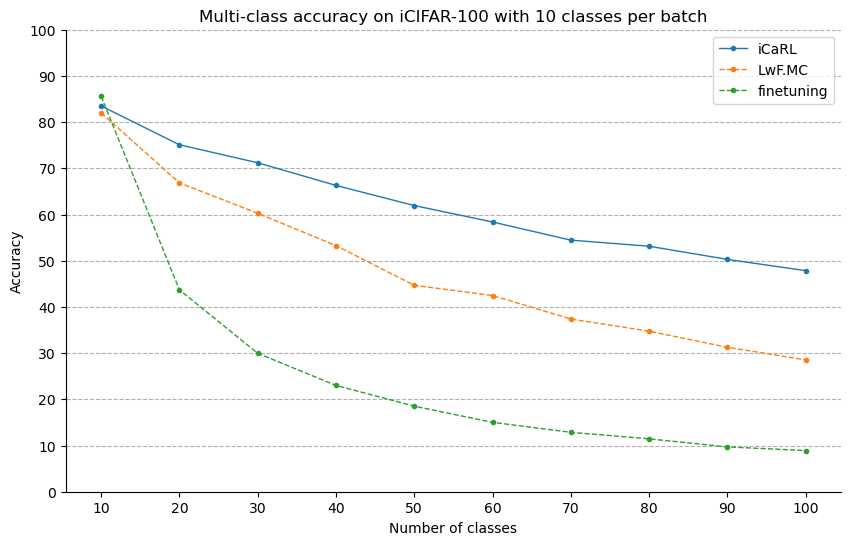

In [2]:
# Load the results
acc_icarl = np.load('top1_acc_list_cumul_icarl_cl10.npy')
acc_lwf = np.load('top1_acc_list_cumul_lwfmc_cl10.npy')
acc_finetuning = np.load('top1_acc_list_cumul_finetuning_cl10.npy')

# Plot the accuracy
fig = plt.figure(figsize=(10, 6))
plt.plot(acc_icarl, '-o', label='iCaRL', markersize=3, lw=1)
plt.plot(acc_lwf, linestyle='dashed', marker='o', label='LwF.MC', markersize=3, lw=1)
plt.plot(acc_finetuning, linestyle='dashed', marker='o', label='finetuning', markersize=3, lw=1)

plt.ylim(0, 100)
plt.ylabel('Accuracy')
plt.xlabel('Number of classes')
plt.yticks(np.arange(0, 110, 10))
plt.xticks(np.arange(0, 10, 1), np.arange(10, 110, 10))

plt.grid(linestyle='dashed', axis='y')
sns.despine()
plt.title('Multi-class accuracy on iCIFAR-100 with 10 classes per batch')
plt.legend()

plt.show()

Files already downloaded and verified
Files already downloaded and verified


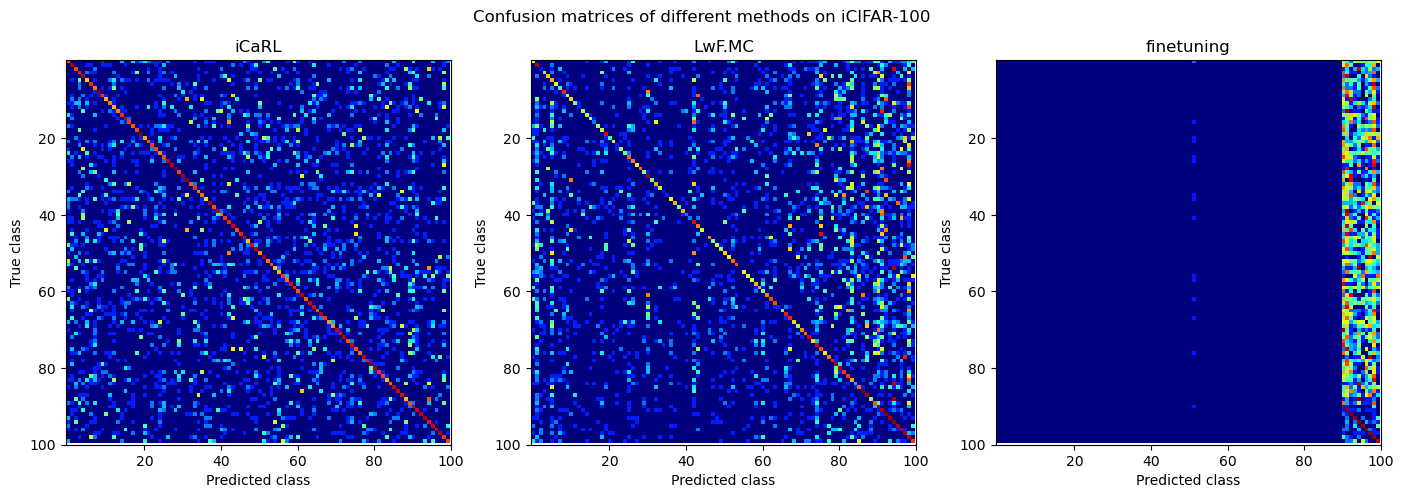

In [3]:
# Load the data
class_means = np.load('cl_means.npy')
order = np.load('order.npy')
data = load_data(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_valid = data['X_test']
y_valid = data['y_test']

# Load the networks
network_icarl = resnet32()
network_icarl.load_state_dict(torch.load('models/network10_of_10.pt'))
network_icarl.eval()
network_icarl.to(device)
network_lwf = resnet32()
network_lwf.load_state_dict(torch.load('models/network10_of_10_lwfmc.pt'))
network_lwf.eval()
network_lwf.to(device)
network_finetuning = resnet32()
network_finetuning.load_state_dict(torch.load('models/network10_of_10_finetuning.pt'))
network_finetuning.eval()
network_finetuning.to(device)

# Get the predictions
y_pred_icarl = torch.zeros_like(y_valid)
y_pred_lwf = torch.zeros_like(y_valid)
y_pred_finetuning = torch.zeros_like(y_valid)

batch_size = 128

for i, batch in enumerate(iterate_minibatches(X_valid, y_valid, batch_size, shuffle=False)):
    inputs, targets = batch
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs_lwf = network_lwf(inputs)[0].cpu()
        outputs_finetuning = network_finetuning(inputs)[0].cpu()
        features = network_icarl(inputs)[1].cpu()

    # Normalize
    features = features / features.norm(dim=1)[:, None]
    features = features.numpy()
    # Compute score for iCaRL
    sqd = cdist(class_means.T, features, 'sqeuclidean')
    score_icarl = (-sqd).T

    _, predicted_lwf = torch.max(outputs_lwf.data, 1)
    _, predicted_finetuning = torch.max(outputs_finetuning.data, 1)
    predicted_icarl = torch.from_numpy(score_icarl).argmax(dim=1)

    y_pred_lwf[i*batch_size:(i+1)*batch_size] = predicted_lwf
    y_pred_finetuning[i*batch_size:(i+1)*batch_size] = predicted_finetuning
    y_pred_icarl[i*batch_size:(i+1)*batch_size] = predicted_icarl

# Plot the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

cm_icarl = confusion_matrix(y_valid, y_pred_icarl)[order][:, order]
cm_lwf = confusion_matrix(y_valid, y_pred_lwf)[order][:, order]
cm_finetuning = confusion_matrix(y_valid, y_pred_finetuning)[order][:, order]

disp_icarl = confusion_matrix(y_valid, y_pred_icarl)
disp_lwf = confusion_matrix(y_valid, y_pred_lwf)
disp_finetuning = confusion_matrix(y_valid, y_pred_finetuning)

axes[0].imshow(np.log(1 + cm_icarl), interpolation='nearest', cmap='jet')
axes[0].set_xticks(np.arange(20, 120, 20))
axes[0].set_yticks(np.arange(20, 120, 20))
axes[0].set_xlabel('Predicted class')
axes[0].set_ylabel('True class')
axes[0].set_title('iCaRL')

axes[1].imshow(np.log(1 + cm_lwf), interpolation='nearest', cmap='jet')
axes[1].set_xticks(np.arange(20, 120, 20))
axes[1].set_yticks(np.arange(20, 120, 20))
axes[1].set_xlabel('Predicted class')
axes[1].set_ylabel('True class')
axes[1].set_title('LwF.MC')

axes[2].imshow(np.log(1 + cm_finetuning), interpolation='nearest', cmap='jet')
axes[2].set_xticks(np.arange(20, 120, 20))
axes[2].set_yticks(np.arange(20, 120, 20))
axes[2].set_xlabel('Predicted class')
axes[2].set_ylabel('True class')
axes[2].set_title('finetuning')

plt.suptitle('Confusion matrices of different methods on iCIFAR-100')
plt.show()
